In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from niftystocks import ns
from sklearn.decomposition import PCA
from IPython.display import clear_output

In [3]:
get_nifty50 = ns.get_nifty50_with_ns()
data = yf.download(get_nifty50, start="2020-01-01", end="2021-01-01")

[*********************100%%**********************]  50 of 50 completed

1 Failed download:
['HDFC.NS']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [4]:
returns = data['Adj Close'].pct_change()
returns = returns.iloc[1:]
returns = returns.dropna(axis=1)

/tmp/ipykernel_14891/300305671.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data['Adj Close'].pct_change()


In [5]:
features = ["Mean Returns", "Volatility", "Sharpe Ratio"]
cluster_data = pd.DataFrame(index=returns.columns, columns=features)
cluster_data["Mean Returns"] = returns.mean()
cluster_data["Volatility"] = returns.std()
cluster_data["Sharpe Ratio"] = cluster_data["Mean Returns"] / cluster_data["Volatility"]


In [6]:
cluster_data = cluster_data.dropna(subset=features)

In [7]:
scaled_data = ((cluster_data - cluster_data.min()) / (cluster_data.max() - cluster_data.min())) * 9 + 1

In [9]:
def random_centroids(scaled_data,k):
    centroids = []
    for i in range(k):
        centroid = scaled_data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids,axis=1)    

In [10]:
def get_labels(scaled_data, centroids):
    distances = centroids.apply(lambda x : np.sqrt(((scaled_data - x)**2).sum(axis=1)))
    return distances.idxmin(axis=1)

In [11]:
def new_centroids(scaled_data, labels, k):
    centroids = scaled_data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [12]:
def plot_clusters(scaled_data, labels, centroids, interation):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(scaled_data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title("Iteration: {}".format(interation))
    plt.scatter(data_2d[:,0], data_2d[:,1], c=labels)
    plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='r', s=100)
    plt.show()

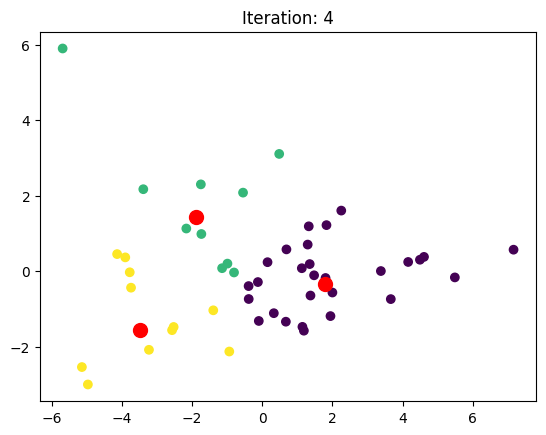

In [17]:
max_iterations = 100
k = 4

centroids = random_centroids(scaled_data, k)
old_centroids = pd.DataFrame() 
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids
    labels = get_labels(scaled_data, centroids)
    centroids = new_centroids(scaled_data,labels,k)
    plot_clusters(scaled_data, labels, centroids, iteration)
    iteration += 1